In [1]:
from typing import List
from MRL import FixedFeatureLayer, Matryoshka_CE_Loss, MRL_Linear_Layer
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normal Encoder

In [3]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9),
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
model = autoencoder()
model.load_state_dict(torch.load("output/autoencoder_weights.pth"))
model.eval()
model.to(device)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=9, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

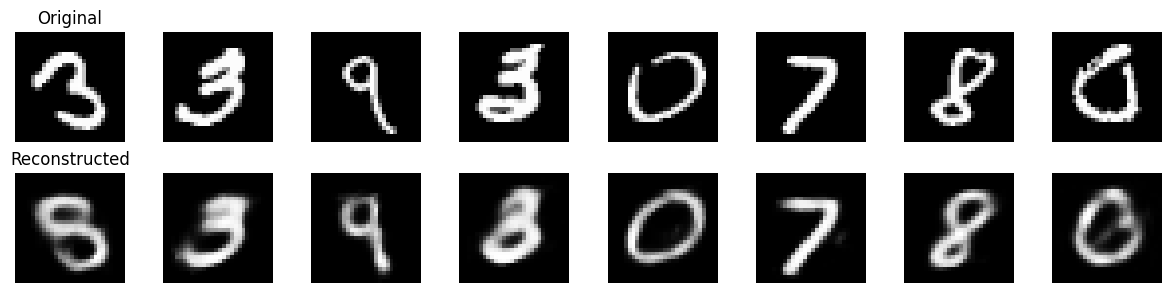

In [5]:
test_dataset = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

images, _ = next(iter(test_loader))
images = images.view(-1, 28 * 28).to(device)

with torch.no_grad():
    recon = model(images)

images = images.view(-1, 28, 28).cpu()
recon = recon.view(-1, 28, 28).cpu()

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(images[i], cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(recon[i], cmap="gray")
    axes[1, i].axis("off")
axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
plt.tight_layout()
plt.savefig("output/reconstruction_output.png")

# MRL Encoder

In [6]:
class MRL_Autoencoder(nn.Module):
    def __init__(self, nesting_list: List[int], num_classes: int, efficient=False):
        super(MRL_Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, nesting_list[-1]),
        )

        self.decoder = nn.Sequential(
            nn.Linear(nesting_list[-1], 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

        self.classifier = MRL_Linear_Layer(
            nesting_list=nesting_list,
            num_classes=num_classes,
            efficient=efficient,
        )

    def forward(self, x):
        z = self.encoder(x)                
        x_recon = self.decoder(z)         
        logits = self.classifier(z)      
        return x_recon, logits

In [7]:
mrl_model = MRL_Autoencoder(nesting_list=[9, 18, 36], num_classes=10).to(device)
mrl_model.load_state_dict(torch.load("output/mrl_autoencoder_weights.pth"))
mrl_model.eval()
mrl_model.to(device)

MRL_Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=36, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
  (classifier): MRL_Linear_Layer(
    (nesting_classifier_0): Linear(in_features=9, out_features=10, bias=True)
    (nesting_classifier_1): Linear(in_features=18, out_features=10, bias=True)
    (nesting_classifier_2): Linear(in_features=36, out_features=10, bias=True)
  )
)

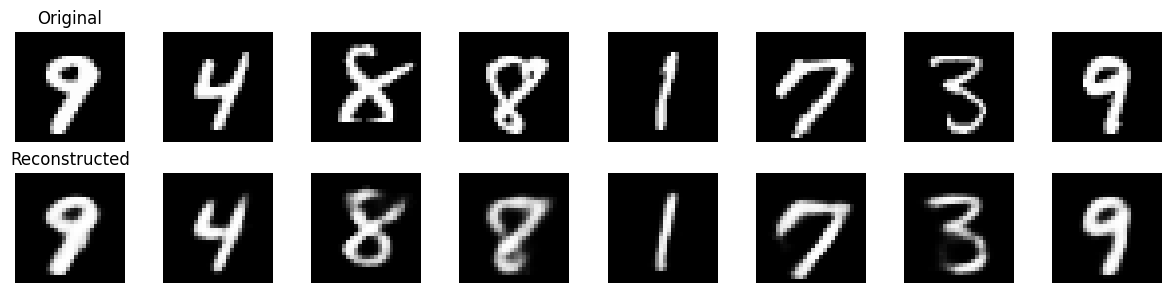

In [8]:
test_dataset = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

images, _ = next(iter(test_loader))
images = images.view(-1, 28 * 28).to(device)

with torch.no_grad():
    recon, _ = mrl_model(images)

images = images.view(-1, 28, 28).cpu()
recon = recon.view(-1, 28, 28).cpu()

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(images[i], cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(recon[i], cmap="gray")
    axes[1, i].axis("off")
axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
plt.tight_layout()
plt.savefig("output/reconstruction_output_mrl.png")